# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

    100% |████████████████████████████████| 14.6MB 37kB/s  eta 0:00:01
  Found existing installation: matplotlib 2.1.0
    Uninstalling matplotlib-2.1.0:
      Successfully uninstalled matplotlib-2.1.0
You are using pip version 9.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

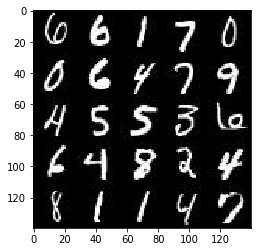

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

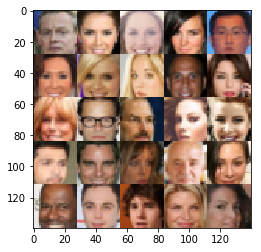

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    real_image = tf.placeholder(tf.float32, shape=[None, image_width, image_height, image_channels], name='real_input')
    Z = tf.placeholder(tf.float32, shape=[None, z_dim], name='z_input')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return real_image, Z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 497, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/tornado/ioloop.py", line 832, in start\n    self._run_callback(self._callbacks.popleft())', 'File

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.nn.relu(x1)
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.nn.relu(bn2)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.nn.relu(bn3)
        
        flat = tf.reshape(relu3, (-1, 4 * 4 * 256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse = not is_train):
        
        x1 = tf.layers.dense(z, 3*3*512)
        x1 = tf.reshape(x1, (-1, 3, 3, 512))
        x1 = tf.layers.batch_normalization(x1, training = is_train)
        x1 = tf.nn.relu(x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides = 2, padding = 'same')
        x2 = tf.layers.batch_normalization(x2, training = is_train)
        x2 = tf.nn.relu(x2)
        
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 4, strides = 2, padding = 'valid')
        x3 = tf.layers.batch_normalization(x3, training = is_train)
        x3 = tf.nn.relu(x3)
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides = 2, padding = 'same')
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    
    generator_model = generator(input_z, out_channel_dim)
        
    discriminator_out_real, discriminator_logits_real = discriminator(input_real)
    discriminator_out_fake, discriminator_logits_fake = discriminator(generator_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = discriminator_logits_real, 
                                                labels = tf.ones_like(discriminator_out_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = discriminator_logits_fake,
                                                labels = tf.zeros_like(discriminator_out_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = discriminator_logits_fake, 
                                                labels = tf.ones_like(discriminator_out_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    train_vars  = tf.trainable_variables()
    
    discriminator_vars = [var for var in train_vars if var.name.startswith('discriminator')]
    generator_vars = [var for var in train_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        discriminator_training_opt = \
        tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=discriminator_vars)
        
        generator_training_opt = \
        tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=generator_vars)
    
    return discriminator_training_opt, generator_training_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [16]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    loss_list = []
    steps = 0
    print_every = 20
    show_every = 100 
    n_images = 9
    
    _, width, height, channels = data_shape
    
    r_input, z_input, lr = model_inputs(width, height, channels, z_dim)
    
    discriminator_loss, generator_loss = model_loss(r_input, z_input, channels)
    discriminator_opt, generator_opt = model_opt(discriminator_loss, generator_loss, lr, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                batch_images = 2 * batch_images
                z_batch = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(discriminator_opt, \
                             feed_dict={r_input : batch_images, z_input : z_batch, lr : learning_rate})
                
                _ = sess.run(generator_opt, \
                             feed_dict={r_input : batch_images, z_input : z_batch, lr : learning_rate})
                
                if steps % print_every == 0:
                    train_loss_discriminator = discriminator_loss.eval({z_input : z_batch, r_input : batch_images})
                    train_loss_generator = generator_loss.eval({z_input : z_batch})
                    
                    print('Epoch {}/{}'.format(epoch_i + 1, epochs), \
                          'Discriminator Loss: {:.4f}'.format(train_loss_discriminator), \
                          'Generator Loss: {:.4f}'.format(train_loss_generator))
                    
                    loss_list.append((train_loss_discriminator, train_loss_generator))
                    
                if steps % show_every == 0:
                    show_generator_output(sess, 25, z_input, channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2 Discriminator Loss: 0.8167 Discriminator Loss: 1.2168
Epoch 1/2 Discriminator Loss: 0.6715 Discriminator Loss: 1.5581
Epoch 1/2 Discriminator Loss: 0.6155 Discriminator Loss: 1.8009
Epoch 1/2 Discriminator Loss: 0.7460 Discriminator Loss: 1.4687
Epoch 1/2 Discriminator Loss: 0.7381 Discriminator Loss: 1.5711


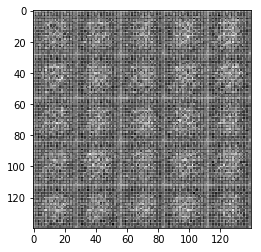

Epoch 1/2 Discriminator Loss: 0.7163 Discriminator Loss: 1.7287
Epoch 1/2 Discriminator Loss: 0.6723 Discriminator Loss: 1.6688
Epoch 1/2 Discriminator Loss: 0.5494 Discriminator Loss: 2.1276
Epoch 1/2 Discriminator Loss: 0.4969 Discriminator Loss: 2.3012
Epoch 1/2 Discriminator Loss: 0.4718 Discriminator Loss: 2.5135


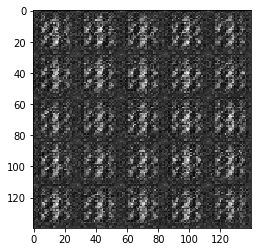

Epoch 1/2 Discriminator Loss: 0.5237 Discriminator Loss: 2.3126
Epoch 1/2 Discriminator Loss: 0.4499 Discriminator Loss: 2.7543
Epoch 1/2 Discriminator Loss: 0.4476 Discriminator Loss: 3.0104
Epoch 1/2 Discriminator Loss: 0.4050 Discriminator Loss: 3.0976
Epoch 1/2 Discriminator Loss: 0.4218 Discriminator Loss: 2.9508


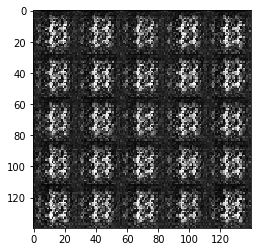

Epoch 1/2 Discriminator Loss: 0.3938 Discriminator Loss: 3.4950
Epoch 1/2 Discriminator Loss: 0.3797 Discriminator Loss: 3.6811
Epoch 1/2 Discriminator Loss: 0.3923 Discriminator Loss: 3.6503
Epoch 1/2 Discriminator Loss: 0.3980 Discriminator Loss: 3.3440
Epoch 1/2 Discriminator Loss: 0.4020 Discriminator Loss: 3.0943


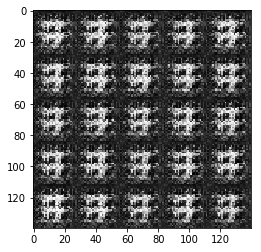

Epoch 1/2 Discriminator Loss: 0.3976 Discriminator Loss: 3.4270
Epoch 1/2 Discriminator Loss: 0.3834 Discriminator Loss: 3.4519
Epoch 1/2 Discriminator Loss: 0.4104 Discriminator Loss: 3.1830
Epoch 1/2 Discriminator Loss: 0.4004 Discriminator Loss: 3.4294
Epoch 1/2 Discriminator Loss: 0.4303 Discriminator Loss: 2.9226


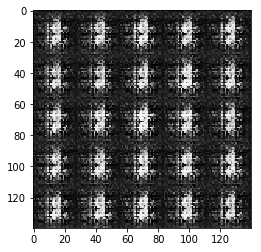

Epoch 1/2 Discriminator Loss: 0.3993 Discriminator Loss: 3.3235
Epoch 1/2 Discriminator Loss: 0.3828 Discriminator Loss: 3.8255
Epoch 1/2 Discriminator Loss: 0.4043 Discriminator Loss: 3.6110
Epoch 1/2 Discriminator Loss: 0.3777 Discriminator Loss: 3.7570
Epoch 1/2 Discriminator Loss: 0.3711 Discriminator Loss: 3.7250


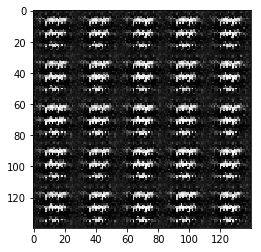

Epoch 1/2 Discriminator Loss: 0.3667 Discriminator Loss: 4.0242
Epoch 1/2 Discriminator Loss: 0.3711 Discriminator Loss: 3.8498
Epoch 1/2 Discriminator Loss: 0.3665 Discriminator Loss: 3.9117
Epoch 1/2 Discriminator Loss: 0.3746 Discriminator Loss: 3.6514
Epoch 1/2 Discriminator Loss: 0.3621 Discriminator Loss: 4.1553


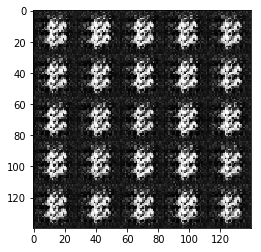

Epoch 1/2 Discriminator Loss: 0.3570 Discriminator Loss: 4.2106
Epoch 1/2 Discriminator Loss: 0.3571 Discriminator Loss: 4.4289
Epoch 1/2 Discriminator Loss: 0.3476 Discriminator Loss: 4.8832
Epoch 1/2 Discriminator Loss: 0.3494 Discriminator Loss: 4.9622
Epoch 1/2 Discriminator Loss: 0.3446 Discriminator Loss: 4.9535


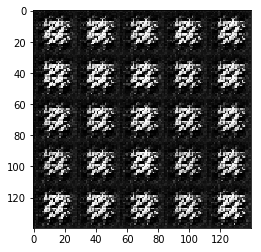

Epoch 1/2 Discriminator Loss: 0.3519 Discriminator Loss: 4.5576
Epoch 1/2 Discriminator Loss: 0.3507 Discriminator Loss: 4.4161
Epoch 1/2 Discriminator Loss: 0.3545 Discriminator Loss: 4.3929
Epoch 1/2 Discriminator Loss: 0.3528 Discriminator Loss: 4.7218
Epoch 1/2 Discriminator Loss: 0.3522 Discriminator Loss: 4.5228


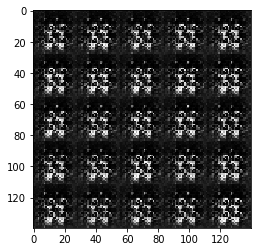

Epoch 1/2 Discriminator Loss: 0.3564 Discriminator Loss: 4.1083
Epoch 2/2 Discriminator Loss: 0.3462 Discriminator Loss: 4.8392
Epoch 2/2 Discriminator Loss: 0.3452 Discriminator Loss: 5.0520
Epoch 2/2 Discriminator Loss: 0.3491 Discriminator Loss: 4.9702
Epoch 2/2 Discriminator Loss: 0.3529 Discriminator Loss: 4.3328


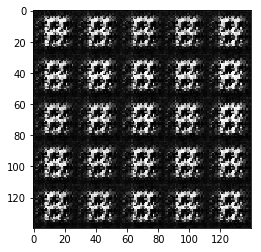

Epoch 2/2 Discriminator Loss: 0.3476 Discriminator Loss: 4.7589
Epoch 2/2 Discriminator Loss: 0.3493 Discriminator Loss: 4.7897
Epoch 2/2 Discriminator Loss: 0.3433 Discriminator Loss: 5.2137
Epoch 2/2 Discriminator Loss: 0.3517 Discriminator Loss: 4.2990
Epoch 2/2 Discriminator Loss: 0.3602 Discriminator Loss: 3.8515


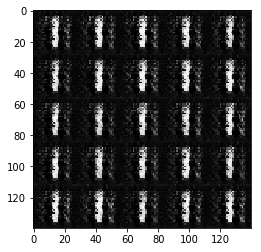

Epoch 2/2 Discriminator Loss: 0.3718 Discriminator Loss: 3.8264
Epoch 2/2 Discriminator Loss: 0.3577 Discriminator Loss: 4.5082
Epoch 2/2 Discriminator Loss: 0.3471 Discriminator Loss: 5.1421
Epoch 2/2 Discriminator Loss: 0.3436 Discriminator Loss: 4.9945
Epoch 2/2 Discriminator Loss: 0.3486 Discriminator Loss: 5.0368


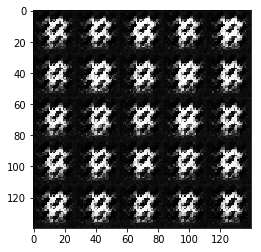

Epoch 2/2 Discriminator Loss: 0.3545 Discriminator Loss: 4.5607
Epoch 2/2 Discriminator Loss: 0.3910 Discriminator Loss: 3.5416
Epoch 2/2 Discriminator Loss: 0.3565 Discriminator Loss: 4.2594
Epoch 2/2 Discriminator Loss: 0.3454 Discriminator Loss: 5.0238
Epoch 2/2 Discriminator Loss: 0.3620 Discriminator Loss: 4.2656


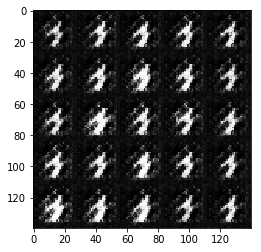

Epoch 2/2 Discriminator Loss: 0.3598 Discriminator Loss: 4.3357
Epoch 2/2 Discriminator Loss: 0.3680 Discriminator Loss: 4.0248
Epoch 2/2 Discriminator Loss: 0.3658 Discriminator Loss: 4.4918
Epoch 2/2 Discriminator Loss: 0.3635 Discriminator Loss: 4.5835
Epoch 2/2 Discriminator Loss: 0.4206 Discriminator Loss: 3.2484


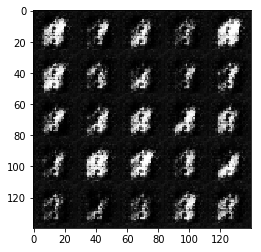

Epoch 2/2 Discriminator Loss: 0.4353 Discriminator Loss: 2.7274
Epoch 2/2 Discriminator Loss: 0.3813 Discriminator Loss: 3.8625
Epoch 2/2 Discriminator Loss: 0.4077 Discriminator Loss: 3.3836
Epoch 2/2 Discriminator Loss: 0.4694 Discriminator Loss: 2.6398
Epoch 2/2 Discriminator Loss: 0.4526 Discriminator Loss: 3.0667


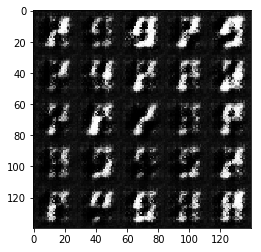

Epoch 2/2 Discriminator Loss: 0.4203 Discriminator Loss: 3.0572
Epoch 2/2 Discriminator Loss: 0.3916 Discriminator Loss: 3.8973
Epoch 2/2 Discriminator Loss: 0.4705 Discriminator Loss: 2.7713
Epoch 2/2 Discriminator Loss: 0.4430 Discriminator Loss: 3.8684
Epoch 2/2 Discriminator Loss: 0.4099 Discriminator Loss: 3.4145


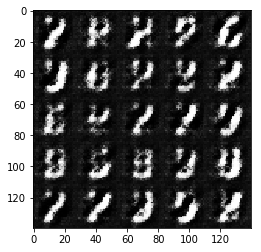

Epoch 2/2 Discriminator Loss: 0.4391 Discriminator Loss: 2.8957
Epoch 2/2 Discriminator Loss: 0.4259 Discriminator Loss: 3.7390
Epoch 2/2 Discriminator Loss: 0.3800 Discriminator Loss: 3.7862
Epoch 2/2 Discriminator Loss: 0.4035 Discriminator Loss: 3.4925
Epoch 2/2 Discriminator Loss: 0.3981 Discriminator Loss: 4.1886


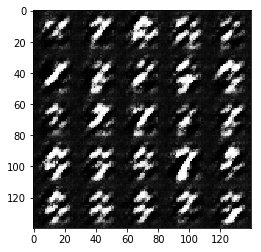

Epoch 2/2 Discriminator Loss: 0.3869 Discriminator Loss: 3.8393
Epoch 2/2 Discriminator Loss: 0.3784 Discriminator Loss: 3.8518
Epoch 2/2 Discriminator Loss: 0.4201 Discriminator Loss: 3.7659
Epoch 2/2 Discriminator Loss: 0.4051 Discriminator Loss: 3.2968
Epoch 2/2 Discriminator Loss: 0.3891 Discriminator Loss: 3.6683


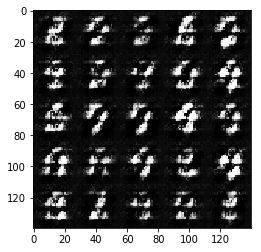

Epoch 2/2 Discriminator Loss: 0.4192 Discriminator Loss: 3.9171
Epoch 2/2 Discriminator Loss: 0.4012 Discriminator Loss: 3.5540
Epoch 2/2 Discriminator Loss: 0.4244 Discriminator Loss: 3.0565


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.00002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1 Discriminator Loss: 1.8699 Generator Loss: 0.2985
Epoch 1/1 Discriminator Loss: 3.5289 Generator Loss: 0.0512
Epoch 1/1 Discriminator Loss: 1.0315 Generator Loss: 2.8135
Epoch 1/1 Discriminator Loss: 1.1300 Generator Loss: 0.9041
Epoch 1/1 Discriminator Loss: 2.2116 Generator Loss: 4.5822


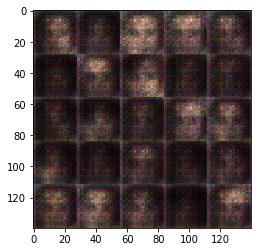

Epoch 1/1 Discriminator Loss: 1.2075 Generator Loss: 1.4293
Epoch 1/1 Discriminator Loss: 1.1194 Generator Loss: 0.9450
Epoch 1/1 Discriminator Loss: 0.8188 Generator Loss: 1.4878
Epoch 1/1 Discriminator Loss: 1.1472 Generator Loss: 0.7826
Epoch 1/1 Discriminator Loss: 0.9732 Generator Loss: 1.8498


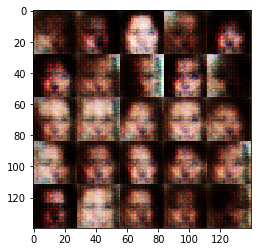

Epoch 1/1 Discriminator Loss: 0.7667 Generator Loss: 1.9930
Epoch 1/1 Discriminator Loss: 2.0198 Generator Loss: 4.4759
Epoch 1/1 Discriminator Loss: 1.5495 Generator Loss: 2.9612
Epoch 1/1 Discriminator Loss: 2.4243 Generator Loss: 0.1667
Epoch 1/1 Discriminator Loss: 0.5549 Generator Loss: 2.4528


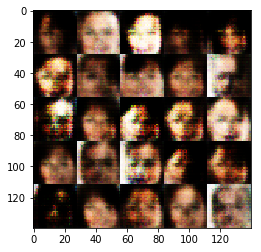

Epoch 1/1 Discriminator Loss: 0.8850 Generator Loss: 3.1724
Epoch 1/1 Discriminator Loss: 1.0699 Generator Loss: 2.3545
Epoch 1/1 Discriminator Loss: 0.5676 Generator Loss: 3.6090
Epoch 1/1 Discriminator Loss: 0.8875 Generator Loss: 0.9997
Epoch 1/1 Discriminator Loss: 0.8651 Generator Loss: 1.3587


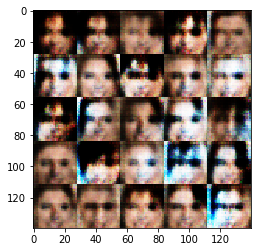

Epoch 1/1 Discriminator Loss: 2.7025 Generator Loss: 0.1184
Epoch 1/1 Discriminator Loss: 0.7489 Generator Loss: 1.2936
Epoch 1/1 Discriminator Loss: 0.6265 Generator Loss: 1.7741
Epoch 1/1 Discriminator Loss: 0.8316 Generator Loss: 3.1932
Epoch 1/1 Discriminator Loss: 0.8873 Generator Loss: 1.8825


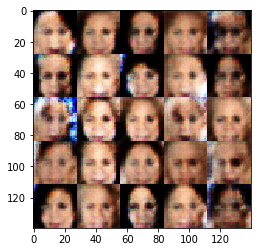

Epoch 1/1 Discriminator Loss: 0.6902 Generator Loss: 1.9032
Epoch 1/1 Discriminator Loss: 0.7146 Generator Loss: 3.7889
Epoch 1/1 Discriminator Loss: 0.9105 Generator Loss: 1.1749
Epoch 1/1 Discriminator Loss: 1.8172 Generator Loss: 0.2957
Epoch 1/1 Discriminator Loss: 0.5196 Generator Loss: 2.1080


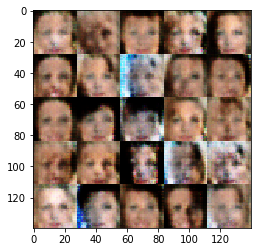

Epoch 1/1 Discriminator Loss: 0.7077 Generator Loss: 1.4259
Epoch 1/1 Discriminator Loss: 0.7752 Generator Loss: 1.1585
Epoch 1/1 Discriminator Loss: 1.2178 Generator Loss: 0.7442
Epoch 1/1 Discriminator Loss: 0.9666 Generator Loss: 1.6151
Epoch 1/1 Discriminator Loss: 0.6564 Generator Loss: 2.4964


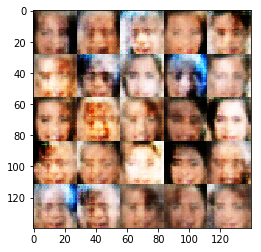

Epoch 1/1 Discriminator Loss: 0.7099 Generator Loss: 1.8536
Epoch 1/1 Discriminator Loss: 0.9471 Generator Loss: 0.9228
Epoch 1/1 Discriminator Loss: 0.6136 Generator Loss: 1.7577
Epoch 1/1 Discriminator Loss: 1.3653 Generator Loss: 0.5096
Epoch 1/1 Discriminator Loss: 0.8418 Generator Loss: 1.1361


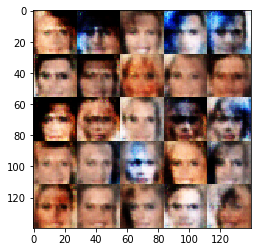

Epoch 1/1 Discriminator Loss: 0.9555 Generator Loss: 3.0470
Epoch 1/1 Discriminator Loss: 0.9269 Generator Loss: 1.3066
Epoch 1/1 Discriminator Loss: 0.9900 Generator Loss: 1.0740
Epoch 1/1 Discriminator Loss: 1.3601 Generator Loss: 0.5734
Epoch 1/1 Discriminator Loss: 1.0021 Generator Loss: 1.0372


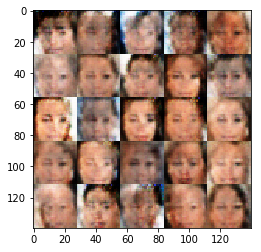

Epoch 1/1 Discriminator Loss: 0.8357 Generator Loss: 1.4697
Epoch 1/1 Discriminator Loss: 0.9841 Generator Loss: 0.9938
Epoch 1/1 Discriminator Loss: 0.9067 Generator Loss: 1.3579
Epoch 1/1 Discriminator Loss: 1.6812 Generator Loss: 3.1250
Epoch 1/1 Discriminator Loss: 1.3731 Generator Loss: 2.6860


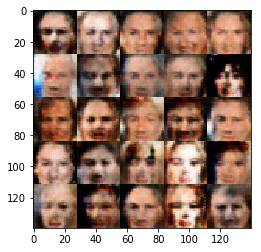

Epoch 1/1 Discriminator Loss: 2.3827 Generator Loss: 4.0746
Epoch 1/1 Discriminator Loss: 0.9525 Generator Loss: 0.9748
Epoch 1/1 Discriminator Loss: 0.7665 Generator Loss: 1.4590
Epoch 1/1 Discriminator Loss: 1.1600 Generator Loss: 0.6668
Epoch 1/1 Discriminator Loss: 1.1232 Generator Loss: 1.4423


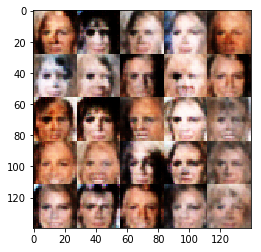

Epoch 1/1 Discriminator Loss: 0.7552 Generator Loss: 3.4707
Epoch 1/1 Discriminator Loss: 0.9551 Generator Loss: 1.0766
Epoch 1/1 Discriminator Loss: 0.5785 Generator Loss: 2.1082
Epoch 1/1 Discriminator Loss: 1.2454 Generator Loss: 0.5874
Epoch 1/1 Discriminator Loss: 0.7374 Generator Loss: 1.4646


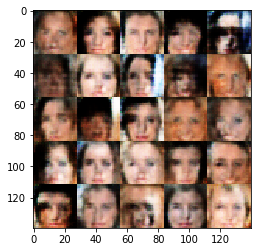

Epoch 1/1 Discriminator Loss: 0.6766 Generator Loss: 1.8080
Epoch 1/1 Discriminator Loss: 0.9035 Generator Loss: 1.5998
Epoch 1/1 Discriminator Loss: 0.7970 Generator Loss: 1.8269
Epoch 1/1 Discriminator Loss: 0.7134 Generator Loss: 1.3012
Epoch 1/1 Discriminator Loss: 0.5226 Generator Loss: 2.5736


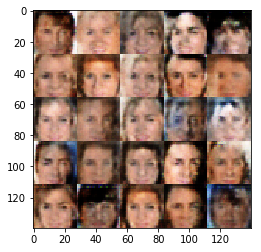

Epoch 1/1 Discriminator Loss: 0.9639 Generator Loss: 0.8981
Epoch 1/1 Discriminator Loss: 1.0401 Generator Loss: 1.2474
Epoch 1/1 Discriminator Loss: 0.8265 Generator Loss: 1.7080
Epoch 1/1 Discriminator Loss: 1.2712 Generator Loss: 1.2596
Epoch 1/1 Discriminator Loss: 1.2153 Generator Loss: 1.9717


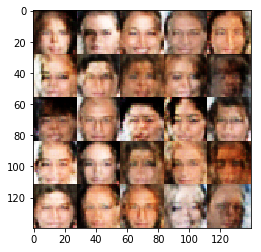

Epoch 1/1 Discriminator Loss: 1.1166 Generator Loss: 1.0467
Epoch 1/1 Discriminator Loss: 1.3198 Generator Loss: 0.5557
Epoch 1/1 Discriminator Loss: 0.5904 Generator Loss: 2.3829
Epoch 1/1 Discriminator Loss: 1.0852 Generator Loss: 1.1051
Epoch 1/1 Discriminator Loss: 0.9460 Generator Loss: 0.8948


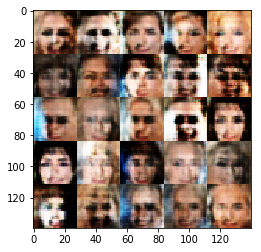

Epoch 1/1 Discriminator Loss: 0.6918 Generator Loss: 1.4158
Epoch 1/1 Discriminator Loss: 1.4350 Generator Loss: 0.5386
Epoch 1/1 Discriminator Loss: 1.0082 Generator Loss: 0.9186
Epoch 1/1 Discriminator Loss: 1.1709 Generator Loss: 0.9103
Epoch 1/1 Discriminator Loss: 0.8975 Generator Loss: 1.0522


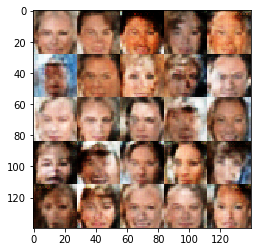

Epoch 1/1 Discriminator Loss: 1.1722 Generator Loss: 0.6599
Epoch 1/1 Discriminator Loss: 1.1283 Generator Loss: 0.7209
Epoch 1/1 Discriminator Loss: 1.1524 Generator Loss: 0.7744
Epoch 1/1 Discriminator Loss: 1.9991 Generator Loss: 3.2520
Epoch 1/1 Discriminator Loss: 1.6313 Generator Loss: 0.4122


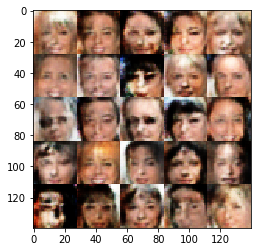

Epoch 1/1 Discriminator Loss: 0.8799 Generator Loss: 1.1175
Epoch 1/1 Discriminator Loss: 0.7746 Generator Loss: 1.3871
Epoch 1/1 Discriminator Loss: 0.7387 Generator Loss: 1.3870
Epoch 1/1 Discriminator Loss: 1.0123 Generator Loss: 1.0759
Epoch 1/1 Discriminator Loss: 1.0226 Generator Loss: 0.7926


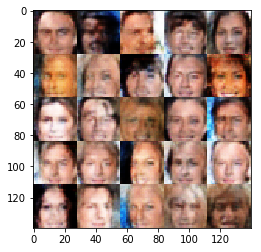

Epoch 1/1 Discriminator Loss: 0.6243 Generator Loss: 1.6138
Epoch 1/1 Discriminator Loss: 0.5937 Generator Loss: 1.8929
Epoch 1/1 Discriminator Loss: 0.5655 Generator Loss: 1.7990
Epoch 1/1 Discriminator Loss: 1.3835 Generator Loss: 0.5013
Epoch 1/1 Discriminator Loss: 1.2239 Generator Loss: 0.6490


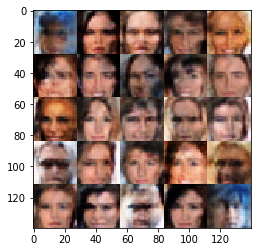

Epoch 1/1 Discriminator Loss: 1.2644 Generator Loss: 0.6360
Epoch 1/1 Discriminator Loss: 1.1016 Generator Loss: 1.9138
Epoch 1/1 Discriminator Loss: 1.0034 Generator Loss: 0.9755
Epoch 1/1 Discriminator Loss: 1.0760 Generator Loss: 1.6493
Epoch 1/1 Discriminator Loss: 1.1296 Generator Loss: 0.7229


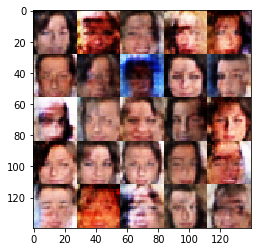

Epoch 1/1 Discriminator Loss: 1.1232 Generator Loss: 1.2874
Epoch 1/1 Discriminator Loss: 0.8567 Generator Loss: 1.5311
Epoch 1/1 Discriminator Loss: 0.7546 Generator Loss: 1.6925
Epoch 1/1 Discriminator Loss: 1.4546 Generator Loss: 0.4995
Epoch 1/1 Discriminator Loss: 1.3454 Generator Loss: 2.0426


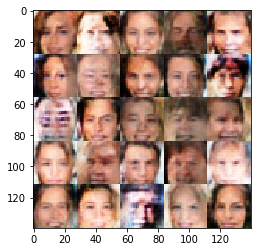

Epoch 1/1 Discriminator Loss: 1.1784 Generator Loss: 0.6593
Epoch 1/1 Discriminator Loss: 1.0030 Generator Loss: 0.8193
Epoch 1/1 Discriminator Loss: 0.8528 Generator Loss: 1.1729
Epoch 1/1 Discriminator Loss: 0.9753 Generator Loss: 1.9739
Epoch 1/1 Discriminator Loss: 1.3785 Generator Loss: 0.5282


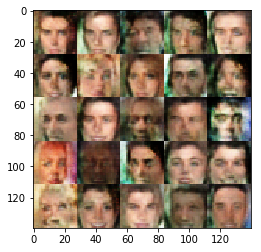

Epoch 1/1 Discriminator Loss: 0.9575 Generator Loss: 1.0188
Epoch 1/1 Discriminator Loss: 0.7131 Generator Loss: 2.6330
Epoch 1/1 Discriminator Loss: 0.4802 Generator Loss: 2.7145
Epoch 1/1 Discriminator Loss: 1.0152 Generator Loss: 2.0967
Epoch 1/1 Discriminator Loss: 1.4332 Generator Loss: 0.4963


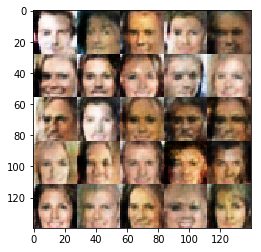

Epoch 1/1 Discriminator Loss: 0.7120 Generator Loss: 1.5868
Epoch 1/1 Discriminator Loss: 1.2439 Generator Loss: 2.7805
Epoch 1/1 Discriminator Loss: 0.7565 Generator Loss: 1.3776
Epoch 1/1 Discriminator Loss: 1.2631 Generator Loss: 0.7709
Epoch 1/1 Discriminator Loss: 0.9758 Generator Loss: 1.3290


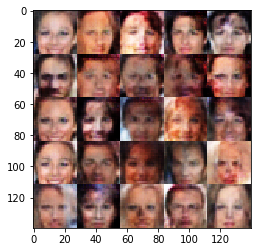

Epoch 1/1 Discriminator Loss: 1.0781 Generator Loss: 0.8254
Epoch 1/1 Discriminator Loss: 0.5522 Generator Loss: 2.3160
Epoch 1/1 Discriminator Loss: 2.0128 Generator Loss: 0.2625
Epoch 1/1 Discriminator Loss: 0.9298 Generator Loss: 1.1693
Epoch 1/1 Discriminator Loss: 1.2114 Generator Loss: 0.7241


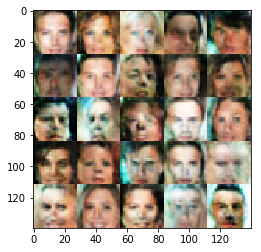

Epoch 1/1 Discriminator Loss: 0.9380 Generator Loss: 1.4167
Epoch 1/1 Discriminator Loss: 0.9682 Generator Loss: 1.3728
Epoch 1/1 Discriminator Loss: 1.0237 Generator Loss: 1.6629
Epoch 1/1 Discriminator Loss: 0.9505 Generator Loss: 1.3288
Epoch 1/1 Discriminator Loss: 1.2527 Generator Loss: 0.6221


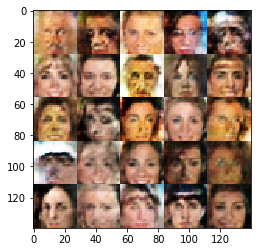

Epoch 1/1 Discriminator Loss: 1.3087 Generator Loss: 0.5811
Epoch 1/1 Discriminator Loss: 0.5354 Generator Loss: 2.3431
Epoch 1/1 Discriminator Loss: 0.9835 Generator Loss: 1.4358
Epoch 1/1 Discriminator Loss: 1.2219 Generator Loss: 0.6730
Epoch 1/1 Discriminator Loss: 0.8631 Generator Loss: 1.6319


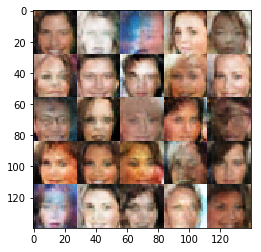

Epoch 1/1 Discriminator Loss: 0.9174 Generator Loss: 0.9389
Epoch 1/1 Discriminator Loss: 1.1555 Generator Loss: 0.6822
Epoch 1/1 Discriminator Loss: 1.0836 Generator Loss: 1.2409
Epoch 1/1 Discriminator Loss: 1.1286 Generator Loss: 0.9917
Epoch 1/1 Discriminator Loss: 1.3341 Generator Loss: 0.5347


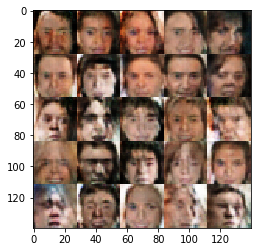

Epoch 1/1 Discriminator Loss: 0.9555 Generator Loss: 1.1048
Epoch 1/1 Discriminator Loss: 1.0491 Generator Loss: 1.7043
Epoch 1/1 Discriminator Loss: 0.8446 Generator Loss: 1.1252
Epoch 1/1 Discriminator Loss: 0.9431 Generator Loss: 1.0704
Epoch 1/1 Discriminator Loss: 1.0853 Generator Loss: 0.8170


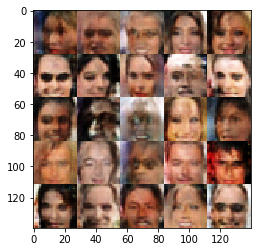

Epoch 1/1 Discriminator Loss: 1.0685 Generator Loss: 1.5456
Epoch 1/1 Discriminator Loss: 1.5360 Generator Loss: 0.4281
Epoch 1/1 Discriminator Loss: 1.1573 Generator Loss: 0.7215
Epoch 1/1 Discriminator Loss: 0.8915 Generator Loss: 1.0229
Epoch 1/1 Discriminator Loss: 1.0195 Generator Loss: 1.0950


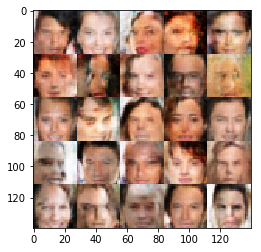

Epoch 1/1 Discriminator Loss: 0.8862 Generator Loss: 1.3394
Epoch 1/1 Discriminator Loss: 1.4104 Generator Loss: 0.5071
Epoch 1/1 Discriminator Loss: 0.9848 Generator Loss: 1.4632
Epoch 1/1 Discriminator Loss: 1.5017 Generator Loss: 0.4605
Epoch 1/1 Discriminator Loss: 1.0480 Generator Loss: 0.8095


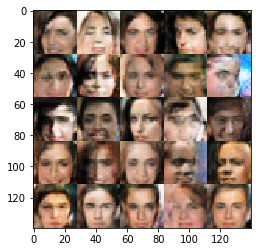

Epoch 1/1 Discriminator Loss: 0.9767 Generator Loss: 1.0677
Epoch 1/1 Discriminator Loss: 1.1847 Generator Loss: 0.7292
Epoch 1/1 Discriminator Loss: 1.1672 Generator Loss: 0.6822


In [19]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.4 #0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.